# Importing, Visualizing, Preprocessing

In [7]:
## Import the dataset. I get better results when I drop "Change" and "Vol"
import pandas as pd
data=pd.read_csv(r'C:\Users\Ali\bitcoin_price.csv')
data = data.drop(["Change %"], axis=1)
data = data.drop(["Vol"], axis=1)
print(data.head())
data.shape

       Date    Price     Open     High      Low
0  5-5-2022  36544.0  39686.0  39833.0  36183.0
1  5-4-2022  39688.0  37717.0  40021.0  37660.0
2  5-3-2022  37718.0  38515.0  38647.0  37513.0
3  5-2-2022  38514.0  38472.0  39134.0  38061.0
4  5-1-2022  38461.0  37642.0  38676.0  37397.0


(4310, 5)

<AxesSubplot:title={'center':'Prices'}, xlabel='Date', ylabel='Price'>

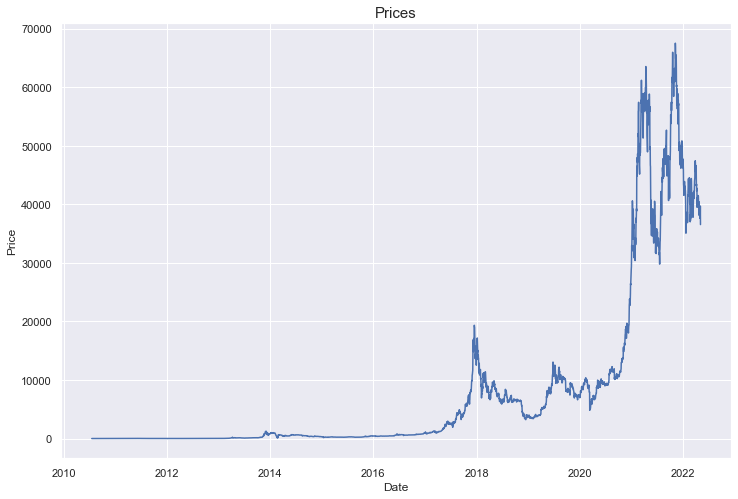

In [8]:
## Graph of price through time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline
data.Date = pd.to_datetime(data.Date)

plt.figure(figsize=(12,8))
plt.title("Prices", fontsize=15)
sns.lineplot(x='Date', y='Price', data=data)

In [9]:
## the training data starts from 2016 because older prices data may not be that valid and it can mislead the training precedure
data_train=data[(data['Date']>='1-1-2016') & (data['Date']<'6-1-2021')]
data_train=data_train.drop(['Date'],axis=1)

data_val=data[(data['Date']>='6-1-2021') & (data['Date']<'1-1-2022')]
data_val=data_val.drop(['Date'],axis=1)

data_test=data[data['Date']>='1-1-2022']
data_test=data_test.drop(['Date'],axis=1)

## Normalize data between 0 and 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
data_train= sc.fit_transform(data_train)
data_val = sc.transform(data_val)
data_test = sc.transform(data_test)

In [10]:
## Creating data. This model uses the past 30 days information in order to predict the next day "Close" Price.

import numpy as np

X_train=[]
y_train=[]
day=30
for i in range(day ,data_train.shape[0]):
  X_train.append(data_train[i-day:i])
  y_train.append(data_train[i,0])

X_train=np.array(X_train)
y_train=np.array(y_train)
y_train=np.reshape(y_train,(y_train.shape[0] , 1))

print("X_train.shape="+str(X_train.shape))
print("y_train.shape="+str(y_train.shape))


X_val=[]
y_val=[]
for i in range(day ,data_val.shape[0]):
  X_val.append(data_val[i-day:i])
  y_val.append(data_val[i,0])

X_val=np.array(X_val)
y_val=np.array(y_val)
y_val=np.reshape(y_val,(y_val.shape[0] , 1))
print("X_val.shape="+str(X_val.shape))
print("y_val.shape="+str(y_val.shape))


X_test=[]
y_test=[]
for i in range(day ,data_test.shape[0]):
  X_test.append(data_test[i-day:i])
  y_test.append(data_test[i,0])

X_test=np.array(X_test)
y_test=np.array(y_test)
y_test=np.reshape(y_test,(y_test.shape[0] , 1))
print("X_test.shape="+str(X_test.shape))
print("y_test.shape="+str(y_test.shape))


X_train.shape=(1948, 30, 4)
y_train.shape=(1948, 1)
X_val.shape=(184, 30, 4)
y_val.shape=(184, 1)
X_test.shape=(95, 30, 4)
y_test.shape=(95, 1)


# Model Implementation

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense , GRU, Flatten

model=Sequential()
model.add(Dense(units = 30,activation='relu', input_shape = (day, 4)))
model.add(Dense(units = 30,activation='relu'))
model.add(GRU(units = 30, return_sequences = True))
model.add(GRU(units = 60, return_sequences = True))
model.add(GRU(units = 90, return_sequences = True))
model.add(GRU(units = 60, return_sequences = True))
model.add(GRU(units = 30, return_sequences = True))
model.add(Flatten())
model.add(Dense(units = 64,activation='relu'))
model.add(Dense(units = 1))

print(model.summary())

model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

prediction_model=model.fit(X_train, y_train,validation_data=(X_val,y_val), epochs =50, batch_size = 16)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 30, 30)            150       
_________________________________________________________________
dense_27 (Dense)             (None, 30, 30)            930       
_________________________________________________________________
gru_30 (GRU)                 (None, 30, 30)            5580      
_________________________________________________________________
gru_31 (GRU)                 (None, 30, 60)            16560     
_________________________________________________________________
gru_32 (GRU)                 (None, 30, 90)            41040     
_________________________________________________________________
gru_33 (GRU)                 (None, 30, 60)            27360     
_________________________________________________________________
gru_34 (GRU)                 (None, 30, 30)           

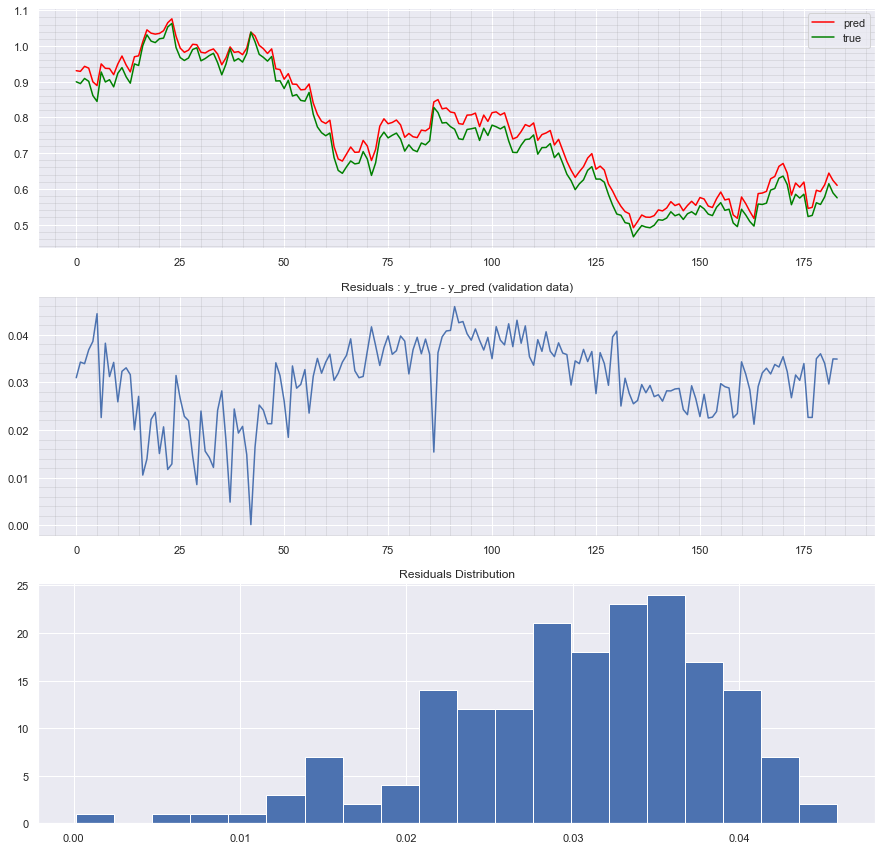

residual mean = 0.030360111604527843 ,  residual variance = 6.676812885655835e-05


In [51]:
## First Lets plot prediction and true values of "Validation Data", we Want to use this data
## in order to estimate the bias of the model so we can compensate that for test data.
model_val=model.predict(X_val)

fig = plt.figure(figsize=(15, 15))
fig.add_subplot(3, 1, 1)
plt.plot(model_val,color='red')
plt.plot(y_val,color='green')
plt.legend(['pred' , 'true'])
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

residual = model_val - y_val
fig.add_subplot(3, 1,2)
plt.plot(residual)
plt.title('Residuals : y_true - y_pred (validation data)')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

fig.add_subplot(3, 1,3)
plt.hist(residual, bins =20)
plt.title('Residuals Distribution')

plt.show()
print("residual mean = " + str(np.mean(residual)) + " ,  residual variance = " + str(np.var(residual)) )

Text(0.5, 1.0, 'Model output for validation data with bias estimation')

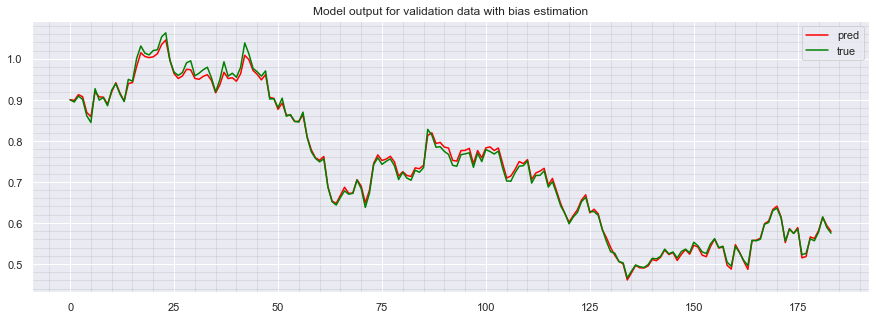

In [53]:
## Model prediction on validation data after compensating fot bias ( mean of erros or residuals)
bias = np.mean(residual)

model_val_unbiased= model_val - bias

fig = plt.figure(figsize=(15, 5))
plt.plot(model_val_unbiased,color='red')
plt.plot(y_val,color='green')
plt.legend(['pred' , 'true'])
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.title('Model output for validation data with bias estimation')

Text(0.5, 1.0, 'Model output for test data with bias estimation')

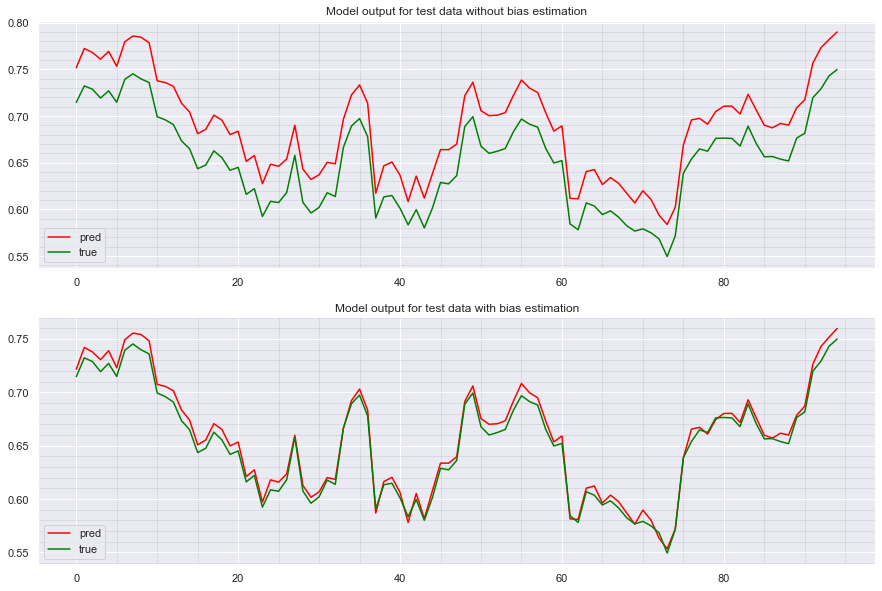

In [50]:
## Now we test the model on test data in 2 cases:

## 1) model without bias estimation :
model_test = model.predict(X_test)

fig = plt.figure(figsize=(15, 10))
fig.add_subplot(2, 1, 1)
plt.plot(model_test ,color='red')
plt.plot(y_test,color='green')
plt.legend(['pred' , 'true'])
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.title('Model output for test data without bias estimation')

## 1) model with bias estimation :
model_test_unbiased= model_test - bias

fig.add_subplot(2, 1, 2)
plt.plot(model_test_unbiased ,color='red')
plt.plot(y_test,color='green')
plt.legend(['pred' , 'true'])
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.title('Model output for test data with bias estimation')


# Final Talk :
Predicting accurate price of some complicated system like bitcoin price is practically impossible.
The most Important thing is predicting the "trend" which means predicting whether the price will go up or down tommorrow
so you can decide your next trading action. This model predicts the trend very well.
Every model has bias. A good model has a "Zero Mean Error" and a very small "Variance".
Here the initial model has both of these properties but for a more accurate prediction I used the error (residuals) on validation data so I can estimate the bias of the model. Then I used that bias value in order to get an "Unbiased Model" which works great on validation data (obviously!) and also improve the results on test data.